# Partition based time series clustering in sktime

Partition based clustering algorithms for time series are those where k
clusters are created from n time series. Each time series inside a cluster
are homogenous (similar) to each other and heterogeneous (dissimilar) to
those outside the cluster.

To measure homogeneity and place a time series into a cluster, a metrics is
used (normally a distance). This metric is used to compare a time
series to k other time series that are representations of each cluster.
These representations are derived using a statistical sampling technique
from when the model was trained. The time series is then assigned to the
cluster that is most similar (or has the best score based on the metric),
and is said to be a part of that cluster.

Currently, in Sktime there are 2 supported partition algorithms supported.
They are: K-means and K-medoids. These will be demonstrated below

## Imports

In [1]:
from sklearn.model_selection import train_test_split

from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from sktime.datasets import load_arrow_head

## Load data

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


## K-partition algorithms

K-partition algorithms are those that seek to create k clusters and assign
each time series to a cluster using a distance measure. In Sktime the
following are currently supported:
<li>K-means - one of the most well known clustering algorithms. The goal of
the K-means algorithm is to minimise a criterion known as the inertia or
within-cluster sum-of-squares (uses the mean of the values in a cluster as
the center).</li>
<li>K-medoids - A similar algorithm to K-means but instead of using the mean of
each cluster to determine the center, the median series is used.
<br><br>
Algorithmically the common way to approach these k-partition algorithms is
known as Lloyds algorithm. This is an iterative process that involves:
<li>Initialisation</li>
<li>Assignment</li>
<li>Updating centroid</li>
<li>Repeat assigment and updating until convergence</li>
<br>

### Center initialisation
Center initialisation is the first step and has been found to be critical in
obtaining good results. There are three main center initialisation that will
now be outlined:
<ul>
    <li> K-means, K-medoids supported center initialisation:
        <ul>
            <li>Random - This is where each sample in the training dataset is
            randomly assigned to a cluster and update centers is run based on
            these random assignments i.e. for k-means the mean of these
            randomly assigned clusters is used and for k-medoids the median of
            these randomly assigned clusters is used as the initial center.</li>
            <li>Forgy - This is where k random samples are chosen from the
            training dataset</li>
            <li>K-means++ - This is where the first center is randomly chosen
            from the training dataset. Then for all the other time series in
            the training dataset, the distance between them and the randomly
            selected center is taken. The next center is then chosen from the
            training dataset so that the probability of being chosen is
            proportional to the distance (i.e. the greater the distance the
            more likely the time series will be chosen). The remaining
            centers are then generated using the same method. Thie means each
            center will be generated so that the probability of a being
            chosen becomes proportional to its closest center (i.e. the further
            from an already chosen center the more likely it will be chosen).
            </li>
         </ul>
     </li>
 </ul>
 <br>
 These three cluster initialisation algorithms have been implemented and can
 be chosen to use when constructing either k-means or k-medoids partitioning
 algorithms by parsing the string values 'random' for random iniitialisation,
 'forgy' for forgy and 'k-means++' for k-means++.

### Assignment (distance measure)
How a time series is assigned to a cluster is based on its distance from it to
the cluster center. This means for some k-partition approaches, different
distances can be used to get different results. While details on each of the
distances won't be discussed here the following are supported, and their
parameter values are defined:
<ul>
    <li>K-means, K-medoids supported distances:
        <ul>
            <li>Euclidean - parameter string 'euclidean'</li>
            <li>DTW - parameter string 'dtw'</li>
            <li>DDTW - parameter string 'ddtw'</li>
            <li>WDTW - parameter string 'wdtw'</li>
            <li>WDDTW - parameter string 'wddtw'</li>
            <li>LCSS - parameter string 'lcss'</li>
            <li>ERP - parameter string 'erp'</li>
            <li>EDR - parameter string 'edr'</li>
            <li>MSM - parameter string 'msm'</li>
        </ul>
    </li>
</ul>

### Updating centroids
Center updating is key to the refinement of clusters to improve their quality.
How this is done depends on the algorithm, but the following are supported
<ul>
    <li> K-means
        <ul>
            <li>Mean average - This is a standard mean average creating a new
             series that is that average of all the series inside the cluster.
             Ideal when using euclidean distance. Can be specified to use
             by parsing 'means' as the parameter for averaging_algorithm to
             k-means</li>
            <li>DTW Barycenter averaging (DBA) - This is a specialised
            averaging metric that is intended to be used with the dtw
            distance measure as it used the dtw matrix path to account for
            allignment when determining an average series. This provides a
            much better representation of the mean for time series. Can be
            specified to use by parsing 'dba' as the parameter for
            averaging_algorithm to k-means.</li>
        </ul>
    </li>
    <li> K-medoids
        <ul>
            <li>Median - Standard meadian which is the series in the middle of
            all series in a cluster. Used by default by k-medoids</li>
        </ul>
   </li>
   </li>
</ul>

## K-means

<Figure size 500x1000 with 0 Axes>

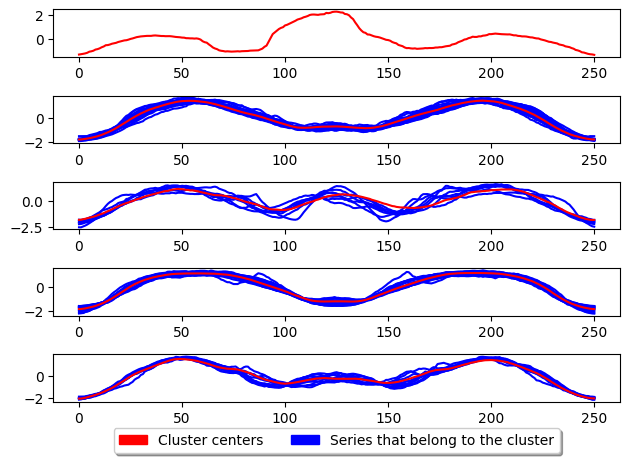

In [4]:
k_means = TimeSeriesKMeans(
    n_clusters=5,  # Number of desired centers
    init_algorithm="forgy",  # Center initialisation technique
    max_iter=3,  # Maximum number of iterations for refinement on training set
    metric="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

## K-medoids

<Figure size 500x1000 with 0 Axes>

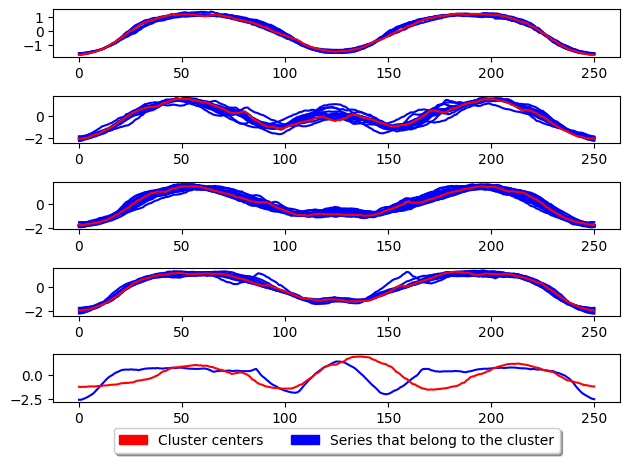

In [6]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=5,  # Number of desired centers
    init_algorithm="forgy",  # Center initialisation technique
    max_iter=3,  # Maximum number of iterations for refinement on training set
    verbose=False,  # Verbose
    metric="dtw",  # Distance metric to use
    random_state=1,
)

k_medoids.fit(X_train)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

The above shows the basic usage for K-medoids. This algorithm
works essentially the same as K-means but instead of updating
the center by taking the mean of the series inside the cluster,
it takes the median series. This means the center is an existing
series in the dataset and NOT a generated one.
<br><br>
The parameter key to k-medoids is the metric and is what we
can adjust to improve performance for time series. An example
of using dtw as the metric is given below.


<Figure size 500x1000 with 0 Axes>

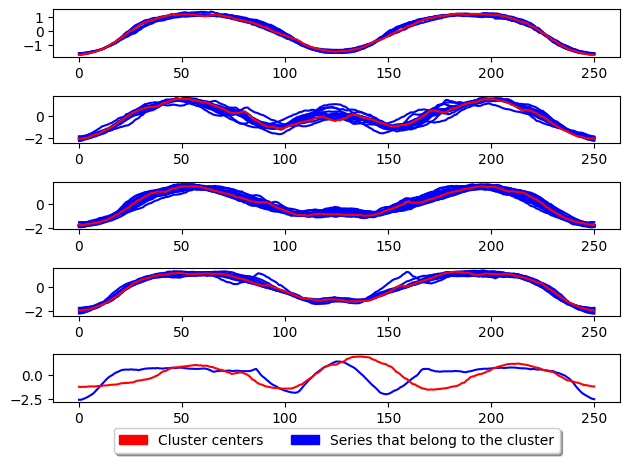

In [7]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=5,  # Number of desired centers
    init_algorithm="forgy",  # Center initialisation technique
    max_iter=3,  # Maximum number of iterations for refinement on training set
    metric="dtw",  # Distance metric to use
    random_state=1,
)

k_medoids.fit(X_train)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)